# Loading Packages

In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, multilabel_confusion_matrix

# GPU 

In [2]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(device)

mps


# MLP definition

In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate):
        super().__init__()
        self.name = 'MLP'
        self.hidden1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.hidden2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.hidden3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.out = nn.Linear(64, output_dim)
    
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = F.relu(self.hidden2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = F.relu(self.hidden3(x))
        x = self.bn3(x)
        x = self.dropout3(x)
        output = torch.sigmoid(self.out(x))
        return output

In [4]:
model = MLP(512, 2, 0.5)
model

MLP(
  (hidden1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (hidden2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (hidden3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=64, out_features=2, bias=True)
)

In [5]:
# model parameter visualization
for name, parameters in model.named_parameters():
    print('parameter name:{}, \n{}, \nparameter size: {}'.
         format(name, parameters, parameters.size()))

parameter name:hidden1.weight, 
Parameter containing:
tensor([[ 0.0170, -0.0075,  0.0141,  ..., -0.0139, -0.0357, -0.0160],
        [ 0.0031,  0.0056, -0.0385,  ..., -0.0186,  0.0036, -0.0085],
        [-0.0047,  0.0137, -0.0279,  ..., -0.0015,  0.0085, -0.0408],
        ...,
        [-0.0208,  0.0019, -0.0198,  ...,  0.0003, -0.0418,  0.0324],
        [-0.0104,  0.0429, -0.0058,  ..., -0.0107, -0.0049,  0.0296],
        [ 0.0169, -0.0421,  0.0278,  ..., -0.0352,  0.0045, -0.0198]],
       requires_grad=True), 
parameter size: torch.Size([256, 512])
parameter name:hidden1.bias, 
Parameter containing:
tensor([ 0.0053, -0.0081, -0.0249,  0.0099, -0.0257, -0.0178,  0.0330, -0.0140,
         0.0064,  0.0274,  0.0278, -0.0167,  0.0147,  0.0048, -0.0048, -0.0275,
         0.0024,  0.0222, -0.0375, -0.0251, -0.0349, -0.0307, -0.0088, -0.0423,
        -0.0335, -0.0246,  0.0161, -0.0152, -0.0158,  0.0358, -0.0043,  0.0133,
        -0.0093, -0.0286,  0.0176, -0.0017,  0.0421,  0.0388,  0.0212,  

# Conv1d definidation

In [6]:
class CONV1D(nn.Module):
    def __init__(self, output_dim, dropout_rate):
        super().__init__()
        self.name = 'Conv1d'
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels = 1,
                      out_channels = 16,
                      kernel_size = 5,
                      padding = 2,
                      stride = 1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 2),
            nn.Dropout(dropout_rate)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels = 16, 
                      out_channels = 32,
                      kernel_size = 5,
                      padding = 2,
                      stride = 1),
            nn.BatchNorm1d(32),
            nn.ReLU(), 
            nn.MaxPool1d(kernel_size = 2),
            nn.Dropout(dropout_rate)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels = 32, 
                      out_channels = 64,
                      kernel_size = 5,
                      padding = 2,
                      stride = 1), 
            nn.BatchNorm1d(64),
            nn.ReLU(), 
            nn.MaxPool1d(kernel_size = 2),
            nn.Dropout(dropout_rate)
        )
        self.fc1 = nn.Linear(64 * 64, 1024)
#         self.fc2 = nn.Linear(1024, 512)
#         self.fc3 = nn.Linear(512, 256)
        self.out = nn.Linear(1024, output_dim)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
        output = torch.sigmoid(self.out(x))
        return output

In [7]:
model = CONV1D(2, 0.5)
model

CONV1D(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (fc1): Linear(in_fe

# Define utils functions

In [8]:
def get_data(X_train, y_train, X_valid, y_valid, batch_size):
    """
    parameters:
    X_train: numpy.array or pandas.DataFrame, the training data
    y_train: numpy.array or pandas.DataFrame, the training label
    X_valid: numpy.array or pandas.DataFrame, the validation data
    y_valid: numpy.array or pandas.DataFrame, the validation label
    batch_size: int, the number of sample in each batch
    """
    # transform the data to tensor dataset
    train_ds = TensorDataset(X_train, y_train)
    valid_ds = TensorDataset(X_valid, y_valid)
    # return the splitted dataset (batches)
    return (DataLoader(train_ds, batch_size = batch_size, shuffle = True), 
           DataLoader(valid_ds, batch_size = batch_size, shuffle = True))

In [9]:
def get_model(model, optimizer, learning_rate, input_dim, output_dim, dropout_rate, weight_decay):
    """
    parameters:
    model: str, the model applied for classification
    optimizer: str, the optimizer applied in model training
    learning_rate: int, the learning rate of model training
    input_dim: int, the dimensionality of input
    oupput_dim: int, the dimensionality of output
    dropout_rate: float, the percentage of dropped neurals
    weight_decay: float, the L2 regularization 
    """
    if model == 'MLP':
        model = MLP(input_dim, output_dim, dropout_rate)
    elif model == 'Conv1d':
        model = CONV1D(output_dim, dropout_rate)
    if optimizer == 'SGD':
        return model.to(device), torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
    else:
        return model.to(device), torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

In [10]:
def batch_train(model, loss_func, xb, yb, optim = None):
    """
    parameters:
    model: the instantiated model, the model applied for training
    loss_func: loss function, the method applied to measure the loss
    xb: tensor, the data of current batch
    yb: tensor, the label of current batch
    optim: optimization function, the function applied to optimize the parameter of the nueral network
    """
    pred_proba = model(xb)
    loss = loss_func(pred_proba, yb)
    # back propagation, parameter optimization
    if optim is not None:
        loss.backward()
        optim.step()
        optim.zero_grad()
    pred = torch.max(pred_proba, 1)[1]
    #pred = torch.argmax(pred_proba)
    return loss.item(), len(xb), list(pred), list(pred_proba[:, 1])

In [11]:
def evaluation(pred, label, proba):
    """
    parameters:
    · pred: predictions of model on testing set
    · label: true class label of testing set
    · proba: the probability of each class
    """
    cm = confusion_matrix(label, pred)
    accuracy = (cm[0, 0] + cm[1, 1]) / len(pred)
    if (cm[0, 1] + cm[1, 1]) == 0:
        precision = 0
    else:
        precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])
    recall = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    f1 = f1_score(label, pred, average='weighted')
    roc_auc = roc_auc_score(label, proba)
    print('confusion matrix: \n{}'.format(cm))
    return [accuracy, precision, recall, specificity, f1, roc_auc]

In [12]:
def plot(X, train_value, valid_value, x_label, y_label, title, figsize, label_1, label_2):
    """
    parameters:
    X: list, the X axis;
    train_value: list, the list of loss/score for training set
    valid_value: list, the list of loss/score for validating set
    x_label: str, the x label of the plot
    y_label: str, the y label of the plot
    title: str, the title of the plot
    figsize: tuple, the size of the plot
    label_1: str, the label of first line
    label_2: str, the label of second line
    """
    plt.figure(figsize = figsize)
    plt.plot(X, train_value, 'b-', label = label_1)
    plt.plot(X, valid_value, 'r-', label = label_2)
    plt.xticks(rotation = 60)
    plt.legend()
    plt.xlabel(x_label, fontweight = 'bold', fontsize = 15) 
    plt.ylabel(y_label, fontweight = 'bold', fontsize = 15)
    plt.title(title, fontweight = 'bold', fontsize = 20)
    plt.show()

In [13]:
def dtype_convert(pred, label, proba):
    pred = [i.cpu() for i in pred]
    label = [i.cpu() for i in label]
    proba = [i.detach().cpu() for i in proba]
    return pred, label, proba

In [14]:
def fit(epochs, model, loss_func, train_dl, valid_dl, optim):
    """
    parameters:
    epochs: int, the number of epoch for model training
    model: the instantiated model, the model applied for training
    loss_func: loss function, the method applied to measure the loss
    train_dl: dataloader instance, the dataloader for model training
    valid_dl: dataloader instance, the dataloader for model validation
    optim: optimization function, the function applied to optimize the parameter of the nueral network
    """
    train_loss_ls = []
    valid_loss_ls = []
    train_scores_ls = []
    valid_scores_ls = []
    for epoch in range(epochs):
        pred_train_ls = []
        proba_train_ls = []
        pred_valid_ls = []
        proba_valid_ls = []
        scores_ls = []
        label_train = []
        label_valid = []
        train_loss_epoch = 0
        valid_loss_epoch = 0

        # model training
        model.train()
        for xb, yb in train_dl:
            if model.name == 'Conv1d':
                xb = xb.unsqueeze(1)
            loss_train, num_train, pred_train, proba_train = batch_train(model, loss_func, xb.float().to(device), yb.to(device), optim)
            pred_train_ls += pred_train
            proba_train_ls += proba_train
            label_train += list(yb)
            train_loss_epoch += loss_train
            
        # model validation
        model.eval()
        with torch.no_grad():
            for xb, yb in valid_dl:
                if model.name == 'Conv1d':
                    xb = xb.unsqueeze(1)
                loss_valid, num_valid, pred_valid, proba_valid = batch_train(model, loss_func, xb.float().to(device), yb.to(device)) 
                pred_valid_ls += pred_valid
                proba_valid_ls += proba_valid
                label_valid += list(yb)
                valid_loss_epoch += loss_valid
                
        # move the data from GPU to CPU
        pred_train_ls, label_train, proba_train_ls = dtype_convert(pred_train_ls, label_train, proba_train_ls)
        pred_valid_ls, label_valid, proba_valid_ls = dtype_convert(pred_valid_ls, label_valid, proba_valid_ls)
                
        # calcualte the training and validating losses
        train_loss = train_loss_epoch / len(train_dl)
        valid_loss = valid_loss_epoch / len(valid_dl)
        train_loss_ls.append(train_loss)
        valid_loss_ls.append(valid_loss)
        
        # disaplay the model performance of current epoch
        print('')
        print(f'epoch: {epoch+1}')
        scores_train = evaluation(pred_train_ls, label_train, proba_train_ls)
        train_scores_ls.append(scores_train)
        print(f'training scores: {list(np.round(np.array(scores_train), 2))}')
        scores_valid = evaluation(pred_valid_ls, label_valid, proba_valid_ls)
        valid_scores_ls.append(scores_valid)
        print(f'validating scores: {list(np.round(np.array(scores_valid), 2))}')
        print('training loss: {}, \nvalidation loss: {}'.format(train_loss, valid_loss))
        
    return model, (train_loss_ls, valid_loss_ls), (train_scores_ls, valid_scores_ls)

# Model training and evaluation

## Auto-encoder
### loading dataset

In [16]:
X_train = pd.read_csv('./Feature Extraction/Auto-encoder/df_X_train.csv').to_numpy()
X_valid = pd.read_csv('./Feature Extraction/Auto-encoder/df_X_test.csv').to_numpy()
y_train = list(pd.read_csv('./Feature Extraction/Auto-encoder/df_y_train.csv')['label'])
y_valid = list(pd.read_csv('./Feature Extraction/Auto-encoder/df_y_test.csv')['label'])

In [20]:
X_train = pd.read_csv('./Feature Extraction/PCA/df_X_train.csv').to_numpy()
X_valid = pd.read_csv('./Feature Extraction/PCA/df_X_test.csv').to_numpy()
y_train = list(pd.read_csv('./Feature Extraction/PCA/df_y_train.csv')['infected'])
y_valid = list(pd.read_csv('./Feature Extraction/PCA/df_y_test.csv')['infected'])

In [24]:
X_train = pd.read_csv('./Feature Extraction/TSNE/df_X_train.csv').to_numpy()
X_valid = pd.read_csv('./Feature Extraction/TSNE/df_X_test.csv').to_numpy()
y_train = list(pd.read_csv('./Feature Extraction/TSNE/df_y_train.csv')['infected'])
y_valid = list(pd.read_csv('./Feature Extraction/TSNE/df_y_test.csv')['infected'])

In [17]:
X_train, y_train, X_valid, y_valid = map(
    torch.tensor, (X_train, y_train, X_valid, y_valid)
)

In [18]:
pd.Series(y_train).value_counts()

1    1263
0    1175
dtype: int64

In [19]:
pd.Series(y_valid).value_counts()

1    541
0    504
dtype: int64

### initialize the parameters 

#### MLP

In [27]:
epochs = 150
batch_size = 64
learning_rate = 0.001
weight_decay = 0.001
input_dim = X_train.shape[1]
output_dim = 2
optimizer = 'Adam'
loss_func = F.cross_entropy
dropout_rate = 0.5
model, optim = get_model('MLP', optimizer, learning_rate, input_dim, output_dim, dropout_rate, weight_decay)
train_dl, valid_dl = get_data(X_train, y_train, X_valid, y_valid, batch_size)

In [28]:
parameter_grids = {
    'epochs' : epochs,
    'model' : model,
    'loss_func': loss_func,
    'train_dl' : train_dl,
    'valid_dl' : valid_dl, 
    'optim' : optim
}

In [29]:
%%time
model, ae_losses, ae_scores = fit(**parameter_grids)


epoch: 1
confusion matrix: 
[[861 314]
 [418 845]]
training scores: [0.7, 0.73, 0.67, 0.73, 0.7, 0.74]
confusion matrix: 
[[496   8]
 [135 406]]
validating scores: [0.86, 0.98, 0.75, 0.98, 0.86, 0.97]
training loss: 0.6140803266794254, 
validation loss: 0.4648751388577854

epoch: 2
confusion matrix: 
[[1095   80]
 [ 140 1123]]
training scores: [0.91, 0.93, 0.89, 0.93, 0.91, 0.96]
confusion matrix: 
[[486  18]
 [ 44 497]]
validating scores: [0.94, 0.97, 0.92, 0.96, 0.94, 0.98]
training loss: 0.44304792468364423, 
validation loss: 0.3806239191223593

epoch: 3
confusion matrix: 
[[1108   67]
 [  82 1181]]
training scores: [0.94, 0.95, 0.94, 0.94, 0.94, 0.98]
confusion matrix: 
[[493  11]
 [ 54 487]]
validating scores: [0.94, 0.98, 0.9, 0.98, 0.94, 0.99]
training loss: 0.39625245256301683, 
validation loss: 0.3785257917993209

epoch: 4
confusion matrix: 
[[1122   53]
 [  65 1198]]
training scores: [0.95, 0.96, 0.95, 0.95, 0.95, 0.99]
confusion matrix: 
[[491  13]
 [ 55 486]]
validating sc


epoch: 31
confusion matrix: 
[[1159   16]
 [  21 1242]]
training scores: [0.98, 0.99, 0.98, 0.99, 0.98, 0.99]
confusion matrix: 
[[491  13]
 [ 34 507]]
validating scores: [0.96, 0.98, 0.94, 0.97, 0.96, 0.98]
training loss: 0.3319398990044227, 
validation loss: 0.3584783235016991

epoch: 32
confusion matrix: 
[[1156   19]
 [  21 1242]]
training scores: [0.98, 0.98, 0.98, 0.98, 0.98, 0.99]
confusion matrix: 
[[493  11]
 [ 41 500]]
validating scores: [0.95, 0.98, 0.92, 0.98, 0.95, 0.99]
training loss: 0.33080430519886506, 
validation loss: 0.3634391321855433

epoch: 33
confusion matrix: 
[[1149   26]
 [  20 1243]]
training scores: [0.98, 0.98, 0.98, 0.98, 0.98, 0.99]
confusion matrix: 
[[494  10]
 [ 48 493]]
validating scores: [0.94, 0.98, 0.91, 0.98, 0.94, 0.99]
training loss: 0.33303424563163364, 
validation loss: 0.3621724703732659

epoch: 34
confusion matrix: 
[[1163   12]
 [  23 1240]]
training scores: [0.99, 0.99, 0.98, 0.99, 0.99, 1.0]
confusion matrix: 
[[492  12]
 [ 37 504]]
val


epoch: 61
confusion matrix: 
[[1159   16]
 [  21 1242]]
training scores: [0.98, 0.99, 0.98, 0.99, 0.98, 1.0]
confusion matrix: 
[[491  13]
 [ 39 502]]
validating scores: [0.95, 0.97, 0.93, 0.97, 0.95, 0.99]
training loss: 0.32908234764368105, 
validation loss: 0.36036936500493216

epoch: 62
confusion matrix: 
[[1162   13]
 [  16 1247]]
training scores: [0.99, 0.99, 0.99, 0.99, 0.99, 1.0]
confusion matrix: 
[[496   8]
 [ 48 493]]
validating scores: [0.95, 0.98, 0.91, 0.98, 0.95, 0.99]
training loss: 0.3307157793106177, 
validation loss: 0.3680490395602058

epoch: 63
confusion matrix: 
[[1158   17]
 [  26 1237]]
training scores: [0.98, 0.99, 0.98, 0.99, 0.98, 1.0]
confusion matrix: 
[[487  17]
 [ 30 511]]
validating scores: [0.96, 0.97, 0.94, 0.97, 0.96, 0.98]
training loss: 0.33680732051531476, 
validation loss: 0.35239312929265637

epoch: 64
confusion matrix: 
[[1162   13]
 [  11 1252]]
training scores: [0.99, 0.99, 0.99, 0.99, 0.99, 1.0]
confusion matrix: 
[[491  13]
 [ 40 501]]
vali


epoch: 91
confusion matrix: 
[[1165   10]
 [  19 1244]]
training scores: [0.99, 0.99, 0.98, 0.99, 0.99, 1.0]
confusion matrix: 
[[491  13]
 [ 28 513]]
validating scores: [0.96, 0.98, 0.95, 0.97, 0.96, 0.99]
training loss: 0.32671840679951203, 
validation loss: 0.3554042455028085

epoch: 92
confusion matrix: 
[[1164   11]
 [  23 1240]]
training scores: [0.99, 0.99, 0.98, 0.99, 0.99, 1.0]
confusion matrix: 
[[487  17]
 [ 27 514]]
validating scores: [0.96, 0.97, 0.95, 0.97, 0.96, 0.99]
training loss: 0.32747863194881344, 
validation loss: 0.3530132367330439

epoch: 93
confusion matrix: 
[[1160   15]
 [   9 1254]]
training scores: [0.99, 0.99, 0.99, 0.99, 0.99, 1.0]
confusion matrix: 
[[494  10]
 [ 33 508]]
validating scores: [0.96, 0.98, 0.94, 0.98, 0.96, 0.99]
training loss: 0.32507383823394775, 
validation loss: 0.35554450399735393

epoch: 94
confusion matrix: 
[[1164   11]
 [  17 1246]]
training scores: [0.99, 0.99, 0.99, 0.99, 0.99, 1.0]
confusion matrix: 
[[493  11]
 [ 31 510]]
vali


epoch: 121
confusion matrix: 
[[1159   16]
 [  23 1240]]
training scores: [0.98, 0.99, 0.98, 0.99, 0.98, 1.0]
confusion matrix: 
[[493  11]
 [ 38 503]]
validating scores: [0.95, 0.98, 0.93, 0.98, 0.95, 0.99]
training loss: 0.3296548441434518, 
validation loss: 0.35897304205333486

epoch: 122
confusion matrix: 
[[1155   20]
 [  17 1246]]
training scores: [0.98, 0.98, 0.99, 0.98, 0.98, 0.99]
confusion matrix: 
[[496   8]
 [ 60 481]]
validating scores: [0.93, 0.98, 0.89, 0.98, 0.93, 0.99]
training loss: 0.3404726233237829, 
validation loss: 0.3739588225589079

epoch: 123
confusion matrix: 
[[1165   10]
 [  24 1239]]
training scores: [0.99, 0.99, 0.98, 0.99, 0.99, 1.0]
confusion matrix: 
[[493  11]
 [ 36 505]]
validating scores: [0.96, 0.98, 0.93, 0.98, 0.96, 0.99]
training loss: 0.3299799951223227, 
validation loss: 0.35663916258250966

epoch: 124
confusion matrix: 
[[1164   11]
 [  32 1231]]
training scores: [0.98, 0.99, 0.97, 0.99, 0.98, 0.99]
confusion matrix: 
[[496   8]
 [ 38 503]]


In [30]:
model.name

'MLP'

In [31]:
model

MLP(
  (hidden1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (hidden2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (hidden3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=64, out_features=2, bias=True)
)

In [32]:
train_losses, valid_losses = ae_losses
plot_parameters = {
    'X' : range(1, epochs+1), 
    'train_value': train_losses, 
    'valid_value' : valid_losses, 
    'x_label' : 'epoch', 
    'y_label': 'loss(cross_entropy)', 
    'title': 'Training loss vs. Validating loss',
    'figsize': (12,8),
    'label_1': 'train',
    'label_2': 'valid'
}

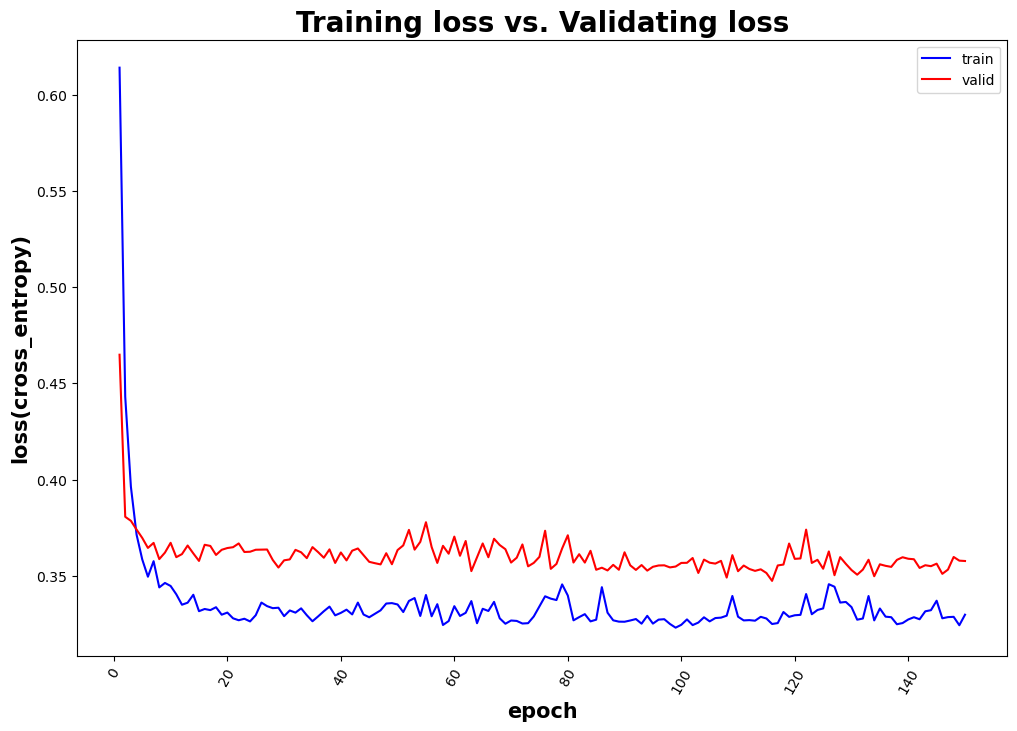

In [33]:
plot(**plot_parameters)

#### Conv1d 

In [48]:
epochs = 500
batch_size = 64
learning_rate = 0.001
weight_decay = 0.001
input_dim = X_train.shape[1]
output_dim = 2
loss_func = F.cross_entropy
optimizer = 'Adam'
dropout_rate = 0.5
model, optim = get_model('Conv1d', 'Adam', learning_rate, input_dim, output_dim, dropout_rate, weight_decay)
train_dl, valid_dl = get_data(X_train, y_train, X_valid, y_valid, batch_size)

In [49]:
parameter_grids = {
    'epochs' : epochs,
    'model' : model,
    'loss_func': loss_func,
    'train_dl' : train_dl,
    'valid_dl' : valid_dl, 
    'optim' : optim
}

In [50]:
%%time
model_conv1d, ae_losses_conv1d, ae_scores_conv1d = fit(**parameter_grids)


epoch: 1
confusion matrix: 
[[  12 1163]
 [  29 1234]]
training scores: [0.51, 0.51, 0.98, 0.01, 0.36, 0.51]
confusion matrix: 
[[  0 504]
 [  0 541]]
validating scores: [0.52, 0.52, 1.0, 0.0, 0.35, 0.63]
training loss: 0.7878865423874978, 
validation loss: 0.7932862429057851

epoch: 2
confusion matrix: 
[[   0 1175]
 [   0 1263]]
training scores: [0.52, 0.52, 1.0, 0.0, 0.35, 0.55]
confusion matrix: 
[[  0 504]
 [  0 541]]
validating scores: [0.52, 0.52, 1.0, 0.0, 0.35, 0.62]
training loss: 0.8033782121462699, 
validation loss: 0.7849618932780098

epoch: 3
confusion matrix: 
[[430 745]
 [339 924]]
training scores: [0.56, 0.55, 0.73, 0.37, 0.54, 0.52]
confusion matrix: 
[[500   4]
 [540   1]]
validating scores: [0.48, 0.2, 0.0, 0.99, 0.31, 0.62]
training loss: 0.7224229146272708, 
validation loss: 0.7760228058871101

epoch: 4
confusion matrix: 
[[564 611]
 [364 899]]
training scores: [0.6, 0.6, 0.71, 0.48, 0.59, 0.47]
confusion matrix: 
[[504   0]
 [541   0]]
validating scores: [0.48, 


epoch: 31
confusion matrix: 
[[ 945  230]
 [ 242 1021]]
training scores: [0.81, 0.82, 0.81, 0.8, 0.81, 0.88]
confusion matrix: 
[[490  14]
 [244 297]]
validating scores: [0.75, 0.95, 0.55, 0.97, 0.74, 0.92]
training loss: 0.4921397238205641, 
validation loss: 0.5404780138941372

epoch: 32
confusion matrix: 
[[ 953  222]
 [ 213 1050]]
training scores: [0.82, 0.83, 0.83, 0.81, 0.82, 0.88]
confusion matrix: 
[[491  13]
 [249 292]]
validating scores: [0.75, 0.96, 0.54, 0.97, 0.74, 0.93]
training loss: 0.48809350301057863, 
validation loss: 0.550967581131879

epoch: 33
confusion matrix: 
[[ 957  218]
 [ 230 1033]]
training scores: [0.82, 0.83, 0.82, 0.81, 0.82, 0.89]
confusion matrix: 
[[477  27]
 [201 340]]
validating scores: [0.78, 0.93, 0.63, 0.95, 0.78, 0.92]
training loss: 0.4875882458992494, 
validation loss: 0.5218256448998171

epoch: 34
confusion matrix: 
[[ 949  226]
 [ 212 1051]]
training scores: [0.82, 0.82, 0.83, 0.81, 0.82, 0.9]
confusion matrix: 
[[485  19]
 [206 335]]
valida


epoch: 61
confusion matrix: 
[[1022  153]
 [ 171 1092]]
training scores: [0.87, 0.88, 0.86, 0.87, 0.87, 0.93]
confusion matrix: 
[[491  13]
 [215 326]]
validating scores: [0.78, 0.96, 0.6, 0.97, 0.77, 0.94]
training loss: 0.4454211073044019, 
validation loss: 0.519955484306111

epoch: 62
confusion matrix: 
[[1017  158]
 [ 173 1090]]
training scores: [0.86, 0.87, 0.86, 0.87, 0.86, 0.93]
confusion matrix: 
[[493  11]
 [216 325]]
validating scores: [0.78, 0.97, 0.6, 0.98, 0.78, 0.94]
training loss: 0.4493087721176637, 
validation loss: 0.5216343928785885

epoch: 63
confusion matrix: 
[[ 970  205]
 [ 178 1085]]
training scores: [0.84, 0.84, 0.86, 0.83, 0.84, 0.92]
confusion matrix: 
[[495   9]
 [246 295]]
validating scores: [0.76, 0.97, 0.55, 0.98, 0.74, 0.93]
training loss: 0.45925317131556, 
validation loss: 0.5459163662265328

epoch: 64
confusion matrix: 
[[1004  171]
 [ 195 1068]]
training scores: [0.85, 0.86, 0.85, 0.85, 0.85, 0.92]
confusion matrix: 
[[495   9]
 [213 328]]
validatin

confusion matrix: 
[[492  12]
 [206 335]]
validating scores: [0.79, 0.97, 0.62, 0.98, 0.79, 0.94]
training loss: 0.44701603589913785, 
validation loss: 0.5096161295385921

epoch: 91
confusion matrix: 
[[1012  163]
 [ 163 1100]]
training scores: [0.87, 0.87, 0.87, 0.86, 0.87, 0.94]
confusion matrix: 
[[478  26]
 [139 402]]
validating scores: [0.84, 0.94, 0.74, 0.95, 0.84, 0.94]
training loss: 0.4369288637087895, 
validation loss: 0.4665324652896208

epoch: 92
confusion matrix: 
[[1018  157]
 [ 147 1116]]
training scores: [0.88, 0.88, 0.88, 0.87, 0.88, 0.94]
confusion matrix: 
[[478  26]
 [138 403]]
validating scores: [0.84, 0.94, 0.74, 0.95, 0.84, 0.94]
training loss: 0.4333483240543268, 
validation loss: 0.46989010537371917

epoch: 93
confusion matrix: 
[[1014  161]
 [ 166 1097]]
training scores: [0.87, 0.87, 0.87, 0.86, 0.87, 0.94]
confusion matrix: 
[[484  20]
 [169 372]]
validating scores: [0.82, 0.95, 0.69, 0.96, 0.82, 0.95]
training loss: 0.4398044431820894, 
validation loss: 0.48


epoch: 120
confusion matrix: 
[[1032  143]
 [ 141 1122]]
training scores: [0.88, 0.89, 0.89, 0.88, 0.88, 0.94]
confusion matrix: 
[[483  21]
 [143 398]]
validating scores: [0.84, 0.95, 0.74, 0.96, 0.84, 0.95]
training loss: 0.43165355233045727, 
validation loss: 0.46403052526361804

epoch: 121
confusion matrix: 
[[1031  144]
 [ 133 1130]]
training scores: [0.89, 0.89, 0.89, 0.88, 0.89, 0.95]
confusion matrix: 
[[476  28]
 [142 399]]
validating scores: [0.84, 0.93, 0.74, 0.94, 0.84, 0.94]
training loss: 0.42921378902899915, 
validation loss: 0.4629778967184179

epoch: 122
confusion matrix: 
[[1028  147]
 [ 146 1117]]
training scores: [0.88, 0.88, 0.88, 0.87, 0.88, 0.94]
confusion matrix: 
[[481  23]
 [160 381]]
validating scores: [0.82, 0.94, 0.7, 0.95, 0.82, 0.95]
training loss: 0.4322973803067819, 
validation loss: 0.47337011204046364

epoch: 123
confusion matrix: 
[[1027  148]
 [ 159 1104]]
training scores: [0.87, 0.88, 0.87, 0.87, 0.87, 0.94]
confusion matrix: 
[[494  10]
 [198 343


epoch: 150
confusion matrix: 
[[1061  114]
 [ 115 1148]]
training scores: [0.91, 0.91, 0.91, 0.9, 0.91, 0.96]
confusion matrix: 
[[491  13]
 [167 374]]
validating scores: [0.83, 0.97, 0.69, 0.97, 0.82, 0.95]
training loss: 0.40365173648565245, 
validation loss: 0.47600677784751444

epoch: 151
confusion matrix: 
[[1051  124]
 [ 134 1129]]
training scores: [0.89, 0.9, 0.89, 0.89, 0.89, 0.95]
confusion matrix: 
[[493  11]
 [167 374]]
validating scores: [0.83, 0.97, 0.69, 0.98, 0.83, 0.95]
training loss: 0.4175769167068677, 
validation loss: 0.4786701938685249

epoch: 152
confusion matrix: 
[[1058  117]
 [ 134 1129]]
training scores: [0.9, 0.91, 0.89, 0.9, 0.9, 0.96]
confusion matrix: 
[[495   9]
 [189 352]]
validating scores: [0.81, 0.98, 0.65, 0.98, 0.81, 0.95]
training loss: 0.41516044659492296, 
validation loss: 0.49510458111763

epoch: 153
confusion matrix: 
[[1063  112]
 [ 138 1125]]
training scores: [0.9, 0.91, 0.89, 0.9, 0.9, 0.96]
confusion matrix: 
[[482  22]
 [132 409]]
validat


epoch: 180
confusion matrix: 
[[1060  115]
 [ 125 1138]]
training scores: [0.9, 0.91, 0.9, 0.9, 0.9, 0.96]
confusion matrix: 
[[483  21]
 [140 401]]
validating scores: [0.85, 0.95, 0.74, 0.96, 0.84, 0.95]
training loss: 0.4088151386150947, 
validation loss: 0.4604642934658948

epoch: 181
confusion matrix: 
[[1056  119]
 [ 134 1129]]
training scores: [0.9, 0.9, 0.89, 0.9, 0.9, 0.96]
confusion matrix: 
[[498   6]
 [228 313]]
validating scores: [0.78, 0.98, 0.58, 0.99, 0.77, 0.95]
training loss: 0.4187197952698439, 
validation loss: 0.5310493742718416

epoch: 182
confusion matrix: 
[[1061  114]
 [ 161 1102]]
training scores: [0.89, 0.91, 0.87, 0.9, 0.89, 0.95]
confusion matrix: 
[[480  24]
 [121 420]]
validating scores: [0.86, 0.95, 0.78, 0.95, 0.86, 0.95]
training loss: 0.4214841081545903, 
validation loss: 0.4457367413184222

epoch: 183
confusion matrix: 
[[1059  116]
 [ 123 1140]]
training scores: [0.9, 0.91, 0.9, 0.9, 0.9, 0.96]
confusion matrix: 
[[493  11]
 [167 374]]
validating sc


epoch: 210
confusion matrix: 
[[1082   93]
 [ 113 1150]]
training scores: [0.92, 0.93, 0.91, 0.92, 0.92, 0.97]
confusion matrix: 
[[500   4]
 [213 328]]
validating scores: [0.79, 0.99, 0.61, 0.99, 0.79, 0.96]
training loss: 0.4014986722897261, 
validation loss: 0.5151935272357043

epoch: 211
confusion matrix: 
[[1075  100]
 [ 129 1134]]
training scores: [0.91, 0.92, 0.9, 0.91, 0.91, 0.97]
confusion matrix: 
[[475  29]
 [105 436]]
validating scores: [0.87, 0.94, 0.81, 0.94, 0.87, 0.95]
training loss: 0.40396972650136703, 
validation loss: 0.43861689111765695

epoch: 212
confusion matrix: 
[[1071  104]
 [ 107 1156]]
training scores: [0.91, 0.92, 0.92, 0.91, 0.91, 0.97]
confusion matrix: 
[[495   9]
 [188 353]]
validating scores: [0.81, 0.98, 0.65, 0.98, 0.81, 0.95]
training loss: 0.40059603406832767, 
validation loss: 0.4940073910881491

epoch: 213
confusion matrix: 
[[1080   95]
 [ 131 1132]]
training scores: [0.91, 0.92, 0.9, 0.92, 0.91, 0.97]
confusion matrix: 
[[494  10]
 [201 340]]


epoch: 240
confusion matrix: 
[[1074  101]
 [ 110 1153]]
training scores: [0.91, 0.92, 0.91, 0.91, 0.91, 0.97]
confusion matrix: 
[[494  10]
 [210 331]]
validating scores: [0.79, 0.97, 0.61, 0.98, 0.78, 0.95]
training loss: 0.40605143171090347, 
validation loss: 0.5205127737101387

epoch: 241
confusion matrix: 
[[1077   98]
 [ 125 1138]]
training scores: [0.91, 0.92, 0.9, 0.92, 0.91, 0.97]
confusion matrix: 
[[484  20]
 [166 375]]
validating scores: [0.82, 0.95, 0.69, 0.96, 0.82, 0.95]
training loss: 0.4035007204764929, 
validation loss: 0.47963129246936126

epoch: 242
confusion matrix: 
[[1078   97]
 [ 117 1146]]
training scores: [0.91, 0.92, 0.91, 0.92, 0.91, 0.96]
confusion matrix: 
[[488  16]
 [155 386]]
validating scores: [0.84, 0.96, 0.71, 0.97, 0.83, 0.95]
training loss: 0.4034274052350949, 
validation loss: 0.478910332216936

epoch: 243
confusion matrix: 
[[1083   92]
 [ 112 1151]]
training scores: [0.92, 0.93, 0.91, 0.92, 0.92, 0.97]
confusion matrix: 
[[484  20]
 [149 392]]



epoch: 270
confusion matrix: 
[[1085   90]
 [ 128 1135]]
training scores: [0.91, 0.93, 0.9, 0.92, 0.91, 0.97]
confusion matrix: 
[[485  19]
 [156 385]]
validating scores: [0.83, 0.95, 0.71, 0.96, 0.83, 0.95]
training loss: 0.403946320215861, 
validation loss: 0.4773835276856142

epoch: 271
confusion matrix: 
[[1087   88]
 [ 106 1157]]
training scores: [0.92, 0.93, 0.92, 0.93, 0.92, 0.97]
confusion matrix: 
[[482  22]
 [145 396]]
validating scores: [0.84, 0.95, 0.73, 0.96, 0.84, 0.95]
training loss: 0.3969846902749477, 
validation loss: 0.46440978961832385

epoch: 272
confusion matrix: 
[[1067  108]
 [  97 1166]]
training scores: [0.92, 0.92, 0.92, 0.91, 0.92, 0.97]
confusion matrix: 
[[492  12]
 [181 360]]
validating scores: [0.82, 0.97, 0.67, 0.98, 0.81, 0.95]
training loss: 0.40000022909580135, 
validation loss: 0.4985271446845111

epoch: 273
confusion matrix: 
[[1093   82]
 [ 103 1160]]
training scores: [0.92, 0.93, 0.92, 0.93, 0.92, 0.97]
confusion matrix: 
[[478  26]
 [120 421]]



epoch: 299
confusion matrix: 
[[1101   74]
 [ 101 1162]]
training scores: [0.93, 0.94, 0.92, 0.94, 0.93, 0.97]
confusion matrix: 
[[487  17]
 [175 366]]
validating scores: [0.82, 0.96, 0.68, 0.97, 0.81, 0.95]
training loss: 0.38858109406935865, 
validation loss: 0.48825230843880596

epoch: 300
confusion matrix: 
[[1099   76]
 [  82 1181]]
training scores: [0.94, 0.94, 0.94, 0.94, 0.94, 0.98]
confusion matrix: 
[[496   8]
 [193 348]]
validating scores: [0.81, 0.98, 0.64, 0.98, 0.8, 0.95]
training loss: 0.38136303959748685, 
validation loss: 0.4919470811591429

epoch: 301
confusion matrix: 
[[1104   71]
 [  93 1170]]
training scores: [0.93, 0.94, 0.93, 0.94, 0.93, 0.98]
confusion matrix: 
[[502   2]
 [244 297]]
validating scores: [0.76, 0.99, 0.55, 1.0, 0.75, 0.95]
training loss: 0.3907424280276665, 
validation loss: 0.5395251074258018

epoch: 302
confusion matrix: 
[[1090   85]
 [ 104 1159]]
training scores: [0.92, 0.93, 0.92, 0.93, 0.92, 0.97]
confusion matrix: 
[[492  12]
 [172 369]]


epoch: 329
confusion matrix: 
[[1081   94]
 [  89 1174]]
training scores: [0.92, 0.93, 0.93, 0.92, 0.92, 0.98]
confusion matrix: 
[[491  13]
 [176 365]]
validating scores: [0.82, 0.97, 0.67, 0.97, 0.82, 0.95]
training loss: 0.38534238170354795, 
validation loss: 0.4818551242351532

epoch: 330
confusion matrix: 
[[1106   69]
 [  96 1167]]
training scores: [0.93, 0.94, 0.92, 0.94, 0.93, 0.98]
confusion matrix: 
[[483  21]
 [128 413]]
validating scores: [0.86, 0.95, 0.76, 0.96, 0.86, 0.96]
training loss: 0.3831156385250581, 
validation loss: 0.4494861679918626

epoch: 331
confusion matrix: 
[[1105   70]
 [  85 1178]]
training scores: [0.94, 0.94, 0.93, 0.94, 0.94, 0.98]
confusion matrix: 
[[491  13]
 [155 386]]
validating scores: [0.84, 0.97, 0.71, 0.97, 0.84, 0.96]
training loss: 0.3832490474749834, 
validation loss: 0.46293171013102813

epoch: 332
confusion matrix: 
[[1085   90]
 [  98 1165]]
training scores: [0.92, 0.93, 0.92, 0.92, 0.92, 0.98]
confusion matrix: 
[[484  20]
 [141 400]

confusion matrix: 
[[486  18]
 [171 370]]
validating scores: [0.82, 0.95, 0.68, 0.96, 0.82, 0.94]
training loss: 0.38285482159027684, 
validation loss: 0.48875544351689953

epoch: 359
confusion matrix: 
[[1098   77]
 [  92 1171]]
training scores: [0.93, 0.94, 0.93, 0.93, 0.93, 0.98]
confusion matrix: 
[[488  16]
 [172 369]]
validating scores: [0.82, 0.96, 0.68, 0.97, 0.82, 0.95]
training loss: 0.3866405410644336, 
validation loss: 0.4774104882689083

epoch: 360
confusion matrix: 
[[1084   91]
 [  99 1164]]
training scores: [0.92, 0.93, 0.92, 0.92, 0.92, 0.97]
confusion matrix: 
[[485  19]
 [149 392]]
validating scores: [0.84, 0.95, 0.72, 0.96, 0.84, 0.95]
training loss: 0.3966293441943633, 
validation loss: 0.47294172118691835

epoch: 361
confusion matrix: 
[[1101   74]
 [  87 1176]]
training scores: [0.93, 0.94, 0.93, 0.94, 0.93, 0.98]
confusion matrix: 
[[493  11]
 [181 360]]
validating scores: [0.82, 0.97, 0.67, 0.98, 0.81, 0.95]
training loss: 0.3806990323922573, 
validation loss: 


epoch: 388
confusion matrix: 
[[1117   58]
 [ 101 1162]]
training scores: [0.93, 0.95, 0.92, 0.95, 0.93, 0.98]
confusion matrix: 
[[484  20]
 [146 395]]
validating scores: [0.84, 0.95, 0.73, 0.96, 0.84, 0.95]
training loss: 0.38189274683976787, 
validation loss: 0.4662090925609364

epoch: 389
confusion matrix: 
[[1109   66]
 [  83 1180]]
training scores: [0.94, 0.95, 0.93, 0.94, 0.94, 0.98]
confusion matrix: 
[[479  25]
 [154 387]]
validating scores: [0.83, 0.94, 0.72, 0.95, 0.83, 0.95]
training loss: 0.3781440685956906, 
validation loss: 0.47207437192692475

epoch: 390
confusion matrix: 
[[1103   72]
 [  90 1173]]
training scores: [0.93, 0.94, 0.93, 0.94, 0.93, 0.98]
confusion matrix: 
[[485  19]
 [180 361]]
validating scores: [0.81, 0.95, 0.67, 0.96, 0.81, 0.94]
training loss: 0.38813147025230604, 
validation loss: 0.4895169857670279

epoch: 391
confusion matrix: 
[[1112   63]
 [  94 1169]]
training scores: [0.94, 0.95, 0.93, 0.95, 0.94, 0.98]
confusion matrix: 
[[479  25]
 [145 396


epoch: 417
confusion matrix: 
[[1093   82]
 [  85 1178]]
training scores: [0.93, 0.93, 0.93, 0.93, 0.93, 0.98]
confusion matrix: 
[[478  26]
 [136 405]]
validating scores: [0.84, 0.94, 0.75, 0.95, 0.84, 0.95]
training loss: 0.38460194453214985, 
validation loss: 0.4570116681211135

epoch: 418
confusion matrix: 
[[1097   78]
 [  88 1175]]
training scores: [0.93, 0.94, 0.93, 0.93, 0.93, 0.98]
confusion matrix: 
[[494  10]
 [201 340]]
validating scores: [0.8, 0.97, 0.63, 0.98, 0.79, 0.95]
training loss: 0.387275870793905, 
validation loss: 0.5046144794015324

epoch: 419
confusion matrix: 
[[1114   61]
 [  98 1165]]
training scores: [0.93, 0.95, 0.92, 0.95, 0.93, 0.98]
confusion matrix: 
[[492  12]
 [191 350]]
validating scores: [0.81, 0.97, 0.65, 0.98, 0.8, 0.94]
training loss: 0.3865610009584671, 
validation loss: 0.4983734032687019

epoch: 420
confusion matrix: 
[[1109   66]
 [  79 1184]]
training scores: [0.94, 0.95, 0.94, 0.94, 0.94, 0.98]
confusion matrix: 
[[482  22]
 [133 408]]
va


epoch: 447
confusion matrix: 
[[1093   82]
 [  98 1165]]
training scores: [0.93, 0.93, 0.92, 0.93, 0.93, 0.98]
confusion matrix: 
[[487  17]
 [172 369]]
validating scores: [0.82, 0.96, 0.68, 0.97, 0.82, 0.95]
training loss: 0.38658182819684345, 
validation loss: 0.4805904276230756

epoch: 448
confusion matrix: 
[[1101   74]
 [  87 1176]]
training scores: [0.93, 0.94, 0.93, 0.94, 0.93, 0.98]
confusion matrix: 
[[494  10]
 [179 362]]
validating scores: [0.82, 0.97, 0.67, 0.98, 0.82, 0.95]
training loss: 0.37951815051910204, 
validation loss: 0.48266033389989066

epoch: 449
confusion matrix: 
[[1107   68]
 [  99 1164]]
training scores: [0.93, 0.94, 0.92, 0.94, 0.93, 0.98]
confusion matrix: 
[[479  25]
 [123 418]]
validating scores: [0.86, 0.94, 0.77, 0.95, 0.86, 0.95]
training loss: 0.38324724023158735, 
validation loss: 0.4449738474453197

epoch: 450
confusion matrix: 
[[1123   52]
 [  73 1190]]
training scores: [0.95, 0.96, 0.94, 0.96, 0.95, 0.98]
confusion matrix: 
[[486  18]
 [150 39


epoch: 477
confusion matrix: 
[[1097   78]
 [  91 1172]]
training scores: [0.93, 0.94, 0.93, 0.93, 0.93, 0.98]
confusion matrix: 
[[491  13]
 [175 366]]
validating scores: [0.82, 0.97, 0.68, 0.97, 0.82, 0.95]
training loss: 0.383241831492155, 
validation loss: 0.4824203954023473

epoch: 478
confusion matrix: 
[[1089   86]
 [  76 1187]]
training scores: [0.93, 0.93, 0.94, 0.93, 0.93, 0.98]
confusion matrix: 
[[497   7]
 [192 349]]
validating scores: [0.81, 0.98, 0.65, 0.99, 0.8, 0.95]
training loss: 0.3857699854251666, 
validation loss: 0.5013104712261873

epoch: 479
confusion matrix: 
[[1102   73]
 [  93 1170]]
training scores: [0.93, 0.94, 0.93, 0.94, 0.93, 0.98]
confusion matrix: 
[[494  10]
 [165 376]]
validating scores: [0.83, 0.97, 0.7, 0.98, 0.83, 0.95]
training loss: 0.38244328514123577, 
validation loss: 0.48661449726890116

epoch: 480
confusion matrix: 
[[1101   74]
 [  81 1182]]
training scores: [0.94, 0.94, 0.94, 0.94, 0.94, 0.98]
confusion matrix: 
[[478  26]
 [137 404]]
v

In [51]:
model.name

'Conv1d'

In [52]:
model

CONV1D(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (fc1): Linear(in_fe

In [53]:
train_losses, valid_losses = ae_losses_conv1d
plot_parameters = {
    'X' : range(1, epochs+1), 
    'train_value': train_losses, 
    'valid_value' : valid_losses, 
    'x_label' : 'epoch', 
    'y_label': 'loss(cross_entropy)', 
    'title': 'Training loss vs. Validating loss',
    'figsize': (12,8),
    'label_1': 'train',
    'label_2': 'valid'
}

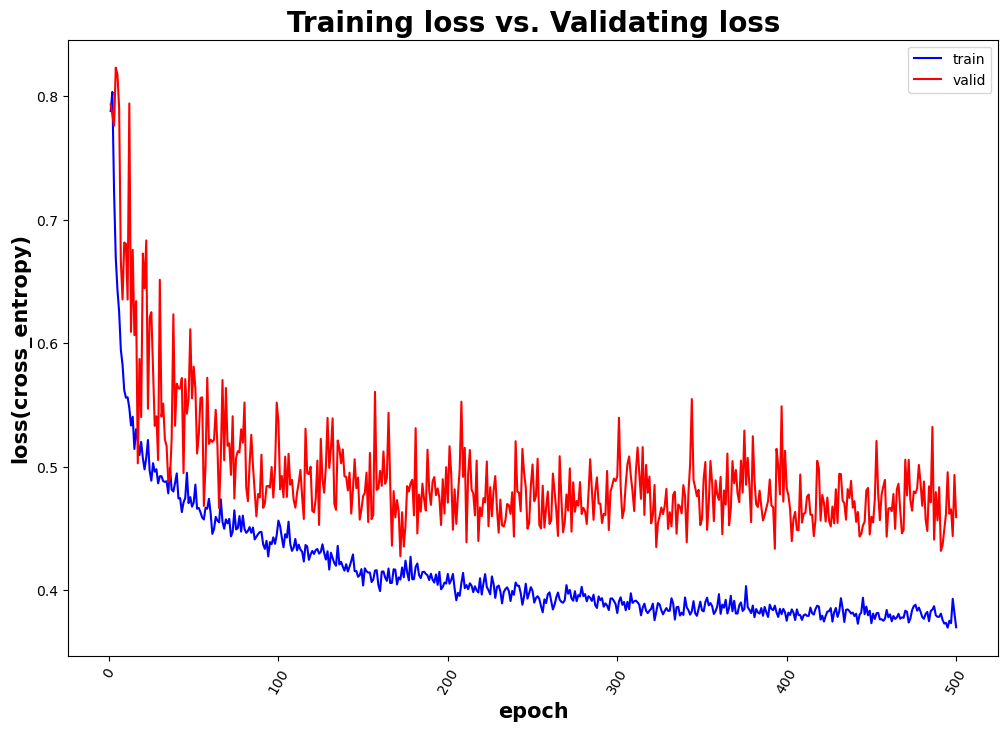

In [54]:
plot(**plot_parameters)

#### MLP vs. Conv1d

In [55]:
def get_scores(scores_ls):
    """
    parameters:
    scores_ls: list(n_epoch, 6), the list store all scores
    """
    accuracy = []
    precision = []
    recall = []
    specificity = []
    f1_scores = []
    roc_auc = []
    for i in range(len(scores_ls)):
        accuracy.append(scores_ls[i][0])
        precision.append(scores_ls[i][1])
        recall.append(scores_ls[i][2])
        specificity.append(scores_ls[i][3])
        f1_scores.append(scores_ls[i][4])
        roc_auc.append(scores_ls[i][5])
    return accuracy, precision, recall, specificity, f1_scores, roc_auc

In [56]:
# get the scores of mlp
train_ae_mlp, test_ae_mlp = ae_scores
acc_train_mlp, pre_train_mlp, recall_train_mlp, speci_train_mlp, f1_train_mlp, auc_train_mlp = get_scores(train_ae_mlp)
acc_valid_mlp, pre_valid_mlp, recall_valid_mlp, speci_valid_mlp, f1_valid_mlp, auc_valid_mlp = get_scores(test_ae_mlp)

In [57]:
# get the scores of conv1d
train_ae_conv1d, test_ae_conv1d = ae_scores_conv1d
acc_train_conv, pre_train_conv, recall_train_conv, speci_train_conv, f1_train_conv, auc_train_conv = get_scores(train_ae_conv1d)
acc_valid_conv, pre_valid_conv, recall_valid_conv, speci_valid_conv, f1_valid_conv, auc_valid_conv = get_scores(test_ae_conv1d)

In [58]:
plot_parameters = {
    'X' : range(1, epochs+1), 
    'train_value': acc_valid_mlp, 
    'valid_value' : acc_valid_conv, 
    'x_label' : 'epoch', 
    'y_label': 'accuracy', 
    'title': 'MLP vs. Conv1d',
    'figsize': (12,8),
    'label_1': 'MLP',
    'label_2': 'Conv1d'
}

In [ ]:
plot(**plot_parameters)

In [565]:
plot_parameters = {
    'X' : range(1, epochs+1), 
    'train_value': recall_valid_mlp, 
    'valid_value' : recall_valid_conv, 
    'x_label' : 'epoch', 
    'y_label': 'recall', 
    'title': 'MLP vs. Conv1d',
    'figsize': (12,8),
    'label_1': 'MLP',
    'label_2': 'Conv1d'
}

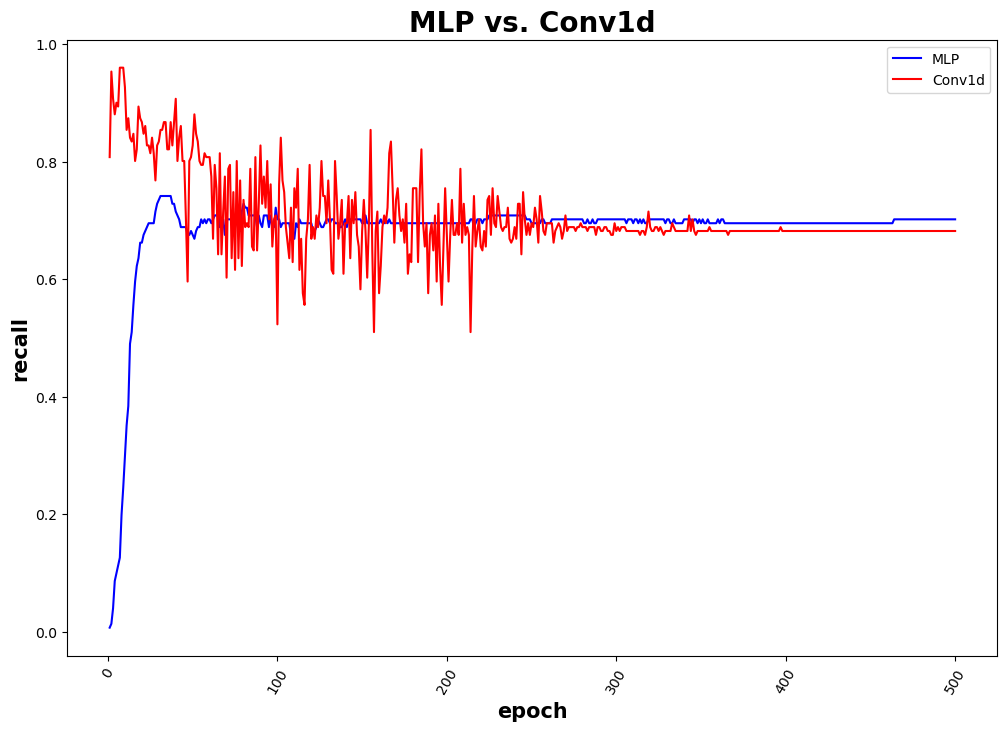

In [566]:
plot(**plot_parameters)

In [567]:
plot_parameters = {
    'X' : range(1, epochs+1), 
    'train_value': speci_valid_mlp, 
    'valid_value' : speci_valid_conv, 
    'x_label' : 'epoch', 
    'y_label': 'specificity', 
    'title': 'MLP vs. Conv1d',
    'figsize': (12,8),
    'label_1': 'MLP',
    'label_2': 'Conv1d'
}

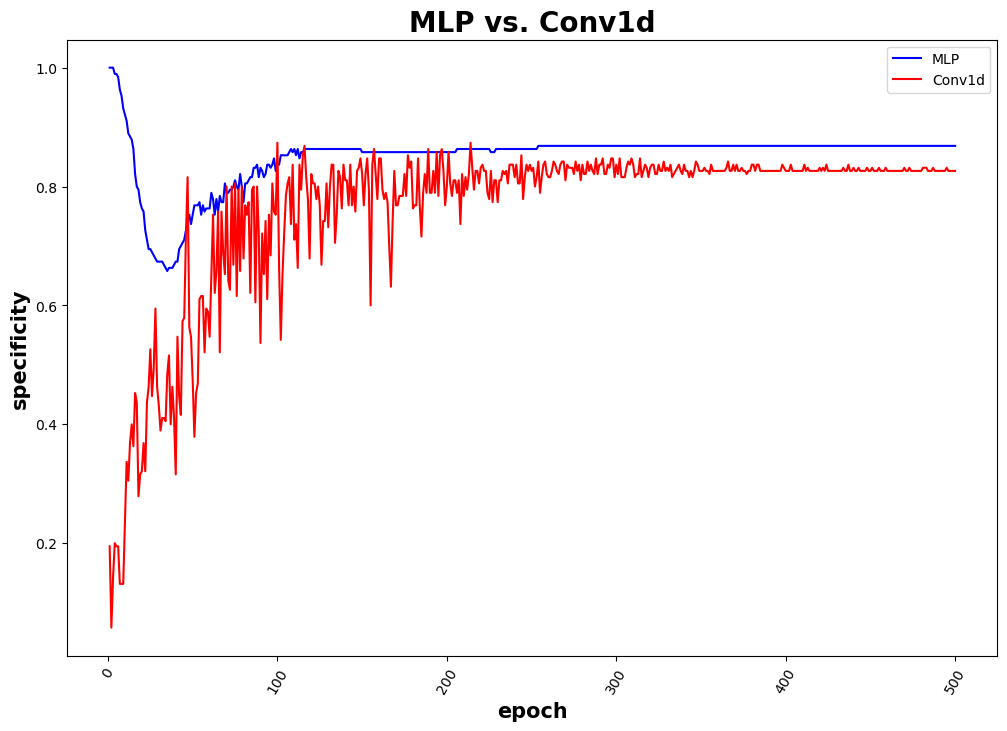

In [568]:
plot(**plot_parameters)

In [569]:
plot_parameters = {
    'X' : range(1, epochs+1), 
    'train_value': auc_valid_mlp, 
    'valid_value' : auc_valid_conv, 
    'x_label' : 'epoch', 
    'y_label': 'ROC_AUC', 
    'title': 'MLP vs. Conv1d',
    'figsize': (12,8),
    'label_1': 'MLP',
    'label_2': 'Conv1d'
}

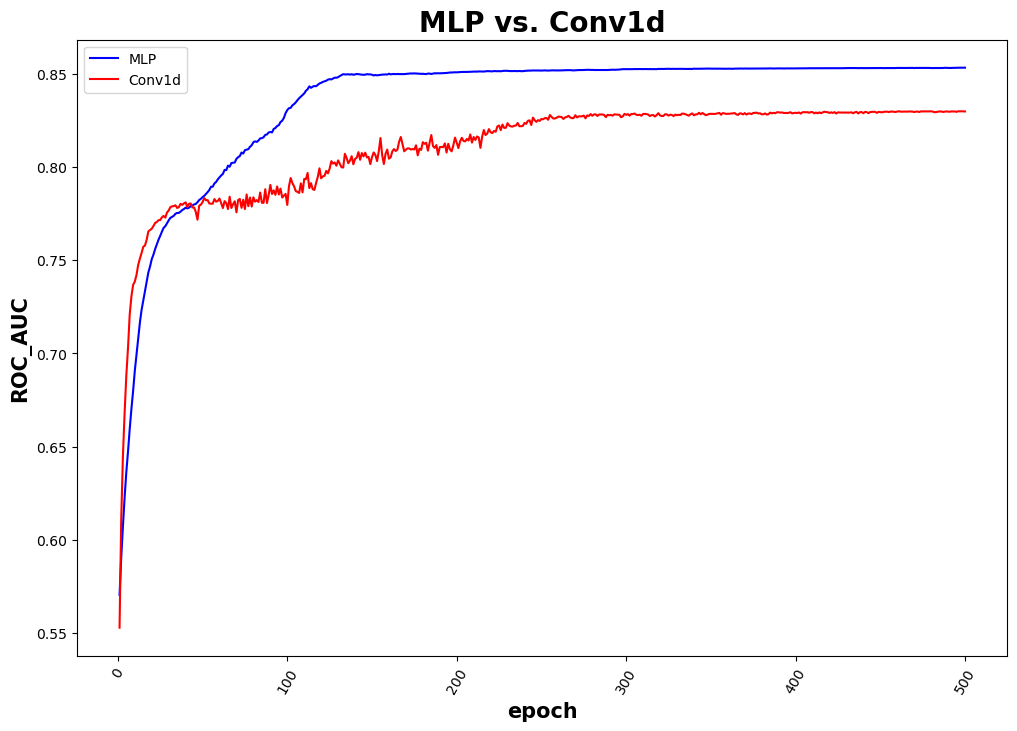

In [570]:
plot(**plot_parameters)